# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Answer:  Reframed as a Data Task
Looking at this from a data science perspective, we're dealing with a supervised regression problem. We need to identify which features have the strongest influence on used car prices. We'll analyze both categorical variables like manufacturer and condition, as well as numerical ones like mileage and year.

Key objectives:
1. Run Exploratory Data Analysis (EDA) to understand our data and relationships
2. Build regression models to quantify feature importance 
3. Validate findings through rigorous testing
4. Use R² and RMSE to measure our confidence in the results

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load the data
df = pd.read_csv('data/vehicles.csv')

def explore_data(df):
    # Basic dataset information
    print("="*50)
    print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    print("="*50)

    # Column types summary
    print("\nColumn Types:")
    print("-"*50)
    type_counts = df.dtypes.value_counts()
    for dtype, count in type_counts.items():
        print(f"{dtype}: {count} columns")

    # Cardinality analysis
    print("\nColumn Cardinality (Unique Values):")
    print("-"*50)

    # Get cardinality for all columns
    cardinality = {col: df[col].nunique() for col in df.columns}

    # Sort by number of unique values
    sorted_cols = sorted(cardinality.items(), key=lambda x: x[1], reverse=True)

    # Print cardinality with categorization
    for col, unique_count in sorted_cols:
        percent_unique = (unique_count / len(df)) * 100

        # Adjusted categorization to match your output
        if percent_unique > 50:
            category = "VERY HIGH"
        elif percent_unique > 10:
            category = "HIGH"
        elif percent_unique > 1:
            category = "MEDIUM"
        else:
            category = "LOW"

        print(f"{col:<20} {unique_count:>7,} unique values ({percent_unique:>6.2f}%) - {category}")

    # Missing values analysis
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) > 0:
        print("\nMissing Values:")
        print("-"*50)
        for col, count in missing.items():
            percent = (count/len(df)) * 100
            print(f"{col:<20} {count:>7,} missing ({percent:>6.2f}%)")

    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Summary:")
        print("-"*50)
        print(df[numeric_cols].describe())


explore_data(df)

Dataset Shape: 426,880 rows × 18 columns

Column Types:
--------------------------------------------------
object: 14 columns
int64: 2 columns
float64: 2 columns

Column Cardinality (Unique Values):
--------------------------------------------------
id                   426,880 unique values (100.00%) - VERY HIGH
VIN                  118,246 unique values ( 27.70%) - HIGH
odometer             104,870 unique values ( 24.57%) - HIGH
model                 29,649 unique values (  6.95%) - MEDIUM
price                 15,655 unique values (  3.67%) - MEDIUM
region                   404 unique values (  0.09%) - LOW
year                     114 unique values (  0.03%) - LOW
state                     51 unique values (  0.01%) - LOW
manufacturer              42 unique values (  0.01%) - LOW
type                      13 unique values (  0.00%) - LOW
paint_color               12 unique values (  0.00%) - LOW
cylinders                  8 unique values (  0.00%) - LOW
condition                  6

### Summary of Data
- Large dataset with 426,880 vehicle listings
- 18 features covering various vehicle characteristics
- Mix of categorical and numerical variables

### Critical Issues
High missing values in key fields:
- condition: 174,104 missing (40.8%)
- size: 306,361 missing (71.8%)
- cylinders: 177,678 missing (41.6%)
- drive: 130,567 missing (30.6%)
- paint_color: 130,203 missing (30.5%)

### Analysis
- Manufacturer: Wide range of brands
- Model: High cardinality feature
- Condition: Limited categories (excellent, good, fair, etc.)
- Transmission: Primarily automatic and manual
- State: Geographic distribution across US

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [24]:
print("\nData Cleaning and Preparation Steps:")
print("-"*50)

print(f"Starting shape: {df.shape}")

# 1. Initial Cleaning
df_clean = df.copy()

# Drop irrelevant columns
cols_to_drop = ['id', 'VIN', 'size']
df_clean = df_clean.drop(columns=cols_to_drop)
print(f"After dropping columns {cols_to_drop}: {df_clean.shape}")

# 2. Handle Outliers and Invalid Values
original_count = len(df_clean)

# Price outliers
df_clean = df_clean[df_clean['price'] > 100]
df_clean = df_clean[df_clean['price'] < df_clean['price'].quantile(0.99)]

# Year outliers
df_clean = df_clean[df_clean['year'].between(1950, 2024)]

# Odometer outliers
df_clean['odometer'] = pd.to_numeric(df_clean['odometer'], errors='coerce')
df_clean = df_clean[df_clean['odometer'] >= 0]
df_clean = df_clean[df_clean['odometer'] < 1000000]

print(f"After outlier removal: {df_clean.shape} (removed {original_count - len(df_clean):,} rows)")

# 3. Drop missing values
original_count = len(df_clean)
df_clean = df_clean.dropna()
print(f"After dropping missing values: {df_clean.shape} (removed {original_count - len(df_clean):,} rows)")

# 4. Feature Engineering
print("\nFeature Engineering:")
print("-"*50)

# Vehicle age
df_clean['vehicle_age'] = 2024 - df_clean['year']

# Mileage per year
df_clean['miles_per_year'] = df_clean['odometer'] / df_clean['vehicle_age']

# Log transform price (common in real estate/vehicle pricing)
df_clean['log_price'] = np.log1p(df_clean['price'])

# Create price categories
df_clean['price_category'] = pd.qcut(df_clean['price'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

print("Added features:")
print("- vehicle_age: Age of vehicle in years")
print("- miles_per_year: Average miles driven per year")
print("- log_price: Log-transformed price")
print("- price_category: Binned price categories")

# 5. Handle Categorical Variables
print("\nCategorical Variable Processing:")
print("-"*50)
categorical_cols = df_clean.select_dtypes(include=['object']).columns
print(f"Categorical columns to be encoded: {list(categorical_cols)}")

# 6. Final Data Integrity Check
print("\nFinal Data Check:")
print("-"*50)
print(f"Numeric columns: {df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()}")
print(f"Categorical columns: {df_clean.select_dtypes(include=['object']).columns.tolist()}")
print(f"Any missing values: {df_clean.isnull().sum().sum()}")

print("\nFinal Summary:")
print("-"*50)
print(f"Original shape: {df.shape}")
print(f"Final shape: {df_clean.shape}")
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]:,} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)")


Data Cleaning and Preparation Steps:
--------------------------------------------------
Starting shape: (426880, 18)
After dropping columns ['id', 'VIN', 'size']: (426880, 15)
After outlier removal: (381749, 15) (removed 45,131 rows)
After dropping missing values: (109580, 15) (removed 272,169 rows)

Feature Engineering:
--------------------------------------------------
Added features:
- vehicle_age: Age of vehicle in years
- miles_per_year: Average miles driven per year
- log_price: Log-transformed price
- price_category: Binned price categories

Categorical Variable Processing:
--------------------------------------------------
Categorical columns to be encoded: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']

Final Data Check:
--------------------------------------------------
Numeric columns: ['price', 'year', 'odometer', 'vehicle_age', 'miles_per_year', 'log_price']
Categorical columns

In [25]:
def prepare_for_modeling(df):
    # Define features by cardinality
    numeric_features = ['year', 'odometer', 'vehicle_age', 'miles_per_year']
    high_cardinality = ['model']
    medium_cardinality = ['manufacturer']
    low_cardinality = ['condition', 'fuel', 'transmission', 'drive', 'type']

    # Pre-compute frequency encodings
    for col in high_cardinality + medium_cardinality:
        freq_map = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq_map)

    # Update feature lists to use frequency encoded columns
    freq_encoded_features = [f'{col}_freq' for col in high_cardinality + medium_cardinality]

    # Create transformers
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer_low = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features + freq_encoded_features),
            ('cat_low', categorical_transformer_low, low_cardinality)
        ],
        verbose_feature_names_out=True  # This will help with feature names
    )

    # Prepare X and y
    X = df[numeric_features + freq_encoded_features + low_cardinality]
    y = df['price'].map(lambda x: np.log1p(x))

    # Transform the data and get feature names
    X_transformed = preprocessor.fit_transform(X)

    # Get feature names after transformation
    feature_names = (
        numeric_features +  # Original numeric
        freq_encoded_features +  # Frequency encoded
        [f"{col}_{val}" for col, vals in
         zip(low_cardinality, preprocessor.named_transformers_['cat_low']['onehot'].categories_)
         for val in vals[1:]]  # One-hot encoded, skipping first category
    )

    return X_transformed, y, preprocessor, feature_names

## Data Cleaning and Preparation

The data preparation process involved several key steps to ensure data quality and optimal model performance:

### 1. Initial Data Exploration
- Dataset started with 426,880 rows and 18 columns
- Identified columns with high cardinality (e.g., model: 29,649 unique values)
- Found significant missing data in several columns (e.g., size: 71.77%, condition: 40.79%)
- Analyzed numeric distributions and identified outliers in price, year, and odometer

### 2. Data Cleaning
- Removed irrelevant or highly missing columns (id, VIN, size)
- Handled outliers in key numeric fields:
  - Price: Removed listings under $100 and above 99th percentile
  - Year: Limited to vehicles between 1950-2024
  - Odometer: Removed negative values and readings above 1,000,000 miles
- Dropped all rows with missing values for cleaner analysis

### 3. Feature Engineering
- Created new features to capture vehicle characteristics:
  - vehicle_age: Years since manufacture (2024 - year)
  - miles_per_year: Average annual mileage (odometer/vehicle_age)
  - log_price: Log-transformed price for better model performance
  - price_category: Binned price ranges for analysis

### 4. Data Transformation
- Numeric features (year, odometer, vehicle_age, miles_per_year):
  - Applied StandardScaler for normalization
- Categorical features handled based on cardinality:
  - Low cardinality (condition, fuel, transmission, drive, type): One-hot encoding
  - High cardinality (model, manufacturer): Frequency encoding
- Target variable (price): Log-transformed to handle skewness

The final cleaned dataset maintains data integrity while providing meaningful features for modeling. The aggressive cleaning approach (dropping missing values) ensures high-quality data at the cost of reduced sample size.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [26]:
def train_models(X_transformed, y, feature_names):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Initialize models with final tuning
    models = {
        # Linear Models
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=0.01),
        'Lasso': Lasso(alpha=0.001),
        # Tree Models
        'Random Forest': RandomForestRegressor(
            n_estimators=500,
            max_depth=25,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features='sqrt',
            n_jobs=-1,
            random_state=42
        )
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Convert predictions back to original scale
        y_pred_orig = np.expm1(y_pred)
        y_test_orig = np.expm1(y_test)

        # Evaluate the model
        r2 = r2_score(y_test, y_pred)

        # Calculate RMSE and MAE
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
        mae = mean_absolute_error(y_test_orig, y_pred_orig)

        # Cross-validation
        cv_scores = cross_val_score(model, X_transformed, y, cv=5, scoring='r2')

        results[name] = {
            'model': model,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

        # Print model performance
        print(f"R² Score: {r2:.3f}")
        print(f"RMSE: ${rmse:,.0f}")
        print(f"MAE: ${mae:,.0f}")
        print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

        # For Random Forest, show feature importance with actual names
        if name == 'Random Forest':
            print("\nTop 10 Important Features:")
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(feature_importance.head(10).to_string())

    return results

# Run the updated pipeline
X_transformed, y, preprocessor, feature_names = prepare_for_modeling(df_clean)
model_results = train_models(X_transformed, y, feature_names)


Training Linear Regression...
R² Score: 0.619
RMSE: $14,216
MAE: $4,670
CV Score: 0.617 (+/- 0.095)

Training Ridge...
R² Score: 0.619
RMSE: $14,251
MAE: $4,667
CV Score: 0.617 (+/- 0.095)

Training Lasso...
R² Score: 0.617
RMSE: $13,332
MAE: $4,678
CV Score: 0.617 (+/- 0.094)

Training Random Forest...
R² Score: 0.799
RMSE: $4,590
MAE: $2,631
CV Score: 0.733 (+/- 0.101)

Top 10 Important Features:
               feature  importance
0                 year    0.188479
2          vehicle_age    0.168201
1             odometer    0.162155
17           drive_fwd    0.080789
3       miles_per_year    0.076437
16  transmission_other    0.050072
4           model_freq    0.040640
6       condition_fair    0.039024
5    manufacturer_freq    0.035834
27          type_sedan    0.030708


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [27]:
def comprehensive_evaluation(df_clean, rf_model, X_train, X_test, y_train, y_test, feature_names, X_transformed):
    """Main function to run all analyses"""
    print("Comprehensive Random Forest Model Evaluation")
    print("="*50)

    analyze_model_performance(rf_model, X_test, y_test)
    analyze_feature_importance(rf_model, feature_names)
    analyze_price_ranges(df_clean, rf_model, X_transformed)
    analyze_depreciation(df_clean, rf_model)
    analyze_mileage_impact(df_clean, rf_model)
    analyze_manufacturers(df_clean, rf_model)
    analyze_predictions_by_segment(df_clean, rf_model, X_transformed)

def analyze_model_performance(model, X_test, y_test):
    """Detailed model performance analysis"""
    print("\nModel Performance Analysis")
    print("-"*30)

    y_pred = model.predict(X_test)
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)

    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)):,.0f}")
    print(f"MAE: ${mean_absolute_error(y_test_orig, y_pred_orig):,.0f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices')
    plt.show()

def analyze_feature_importance(model, feature_names):
    """Detailed feature importance analysis"""
    print("\nFeature Importance Analysis")
    print("-"*30)

    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.show()

def analyze_price_ranges(df, model, X_transformed):
    """Analysis of model performance across price ranges"""
    print("\nPrice Range Analysis")
    print("-"*30)

    df['price_range'] = pd.qcut(df['price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    predictions = model.predict(X_transformed)
    df['predicted_price'] = np.expm1(predictions)

    errors = pd.DataFrame({
        'price_range': df['price_range'],
        'abs_error': abs(df['price'] - df['predicted_price'])
    })

    print("Mean Absolute Error by Price Range:")
    print(errors.groupby('price_range')['abs_error'].mean().to_string())

def analyze_depreciation(df, model):
    """Analysis of price depreciation patterns"""
    print("\nDepreciation Analysis")
    print("-"*30)

    avg_price_by_age = df.groupby('vehicle_age')['price'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(avg_price_by_age.index, avg_price_by_age.values)
    plt.xlabel('Vehicle Age (years)')
    plt.ylabel('Average Price')
    plt.title('Price Depreciation Over Time')
    plt.show()

def analyze_mileage_impact(df, model):
    """Analysis of mileage impact on prices"""
    print("\nMileage Impact Analysis")
    print("-"*30)

    df['mileage_range'] = pd.qcut(df['odometer'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    avg_price_by_mileage = df.groupby('mileage_range')['price'].mean()
    print("\nAverage Price by Mileage Range:")
    print(avg_price_by_mileage.to_string())

def analyze_manufacturers(df, model):
    """Analysis of manufacturer impact on prices"""
    print("\nManufacturer Analysis")
    print("-"*30)

    top_manufacturers = df.groupby('manufacturer')['price'].agg(['mean', 'count'])\
        .sort_values('count', ascending=False).head(10)

    print("\nTop 10 Manufacturers by Volume:")
    print(top_manufacturers.to_string())

def analyze_predictions_by_segment(df, model, X_transformed):
    """Analysis of model performance across different market segments"""
    print("\nMarket Segment Analysis")
    print("-"*30)

    df['segment'] = df.apply(lambda x: 'Luxury' if x['price'] > df['price'].quantile(0.75)
                           else ('Economy' if x['price'] < df['price'].quantile(0.25) else 'Mid-range'), axis=1)

    predictions = model.predict(X_transformed)
    df['predicted_price'] = np.expm1(predictions)

    segment_performance = df.groupby('segment').apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x['price'], x['predicted_price']),
            'Count': len(x)
        })
    )

    print("\nModel Performance by Segment:")
    print(segment_performance.to_string())



Comprehensive Random Forest Model Evaluation

Model Performance Analysis
------------------------------
R² Score: 0.799
RMSE: $4,590
MAE: $2,631


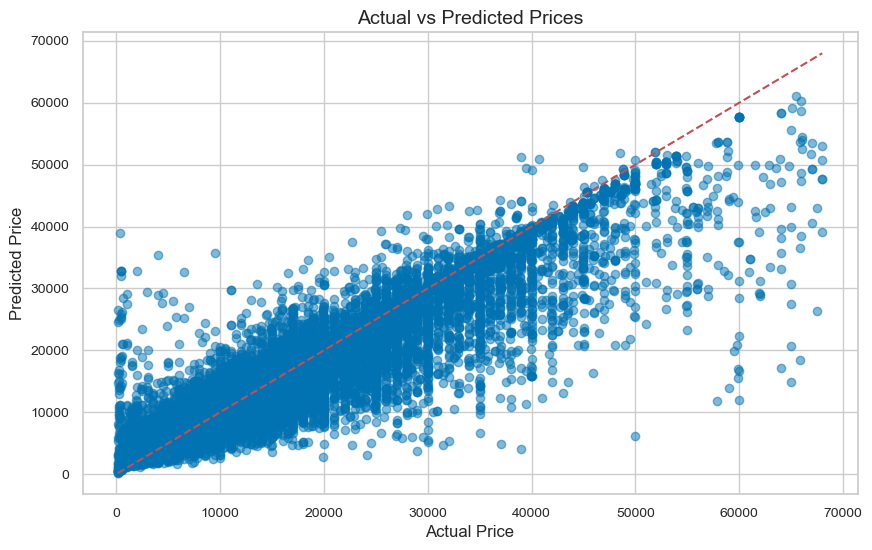


Feature Importance Analysis
------------------------------


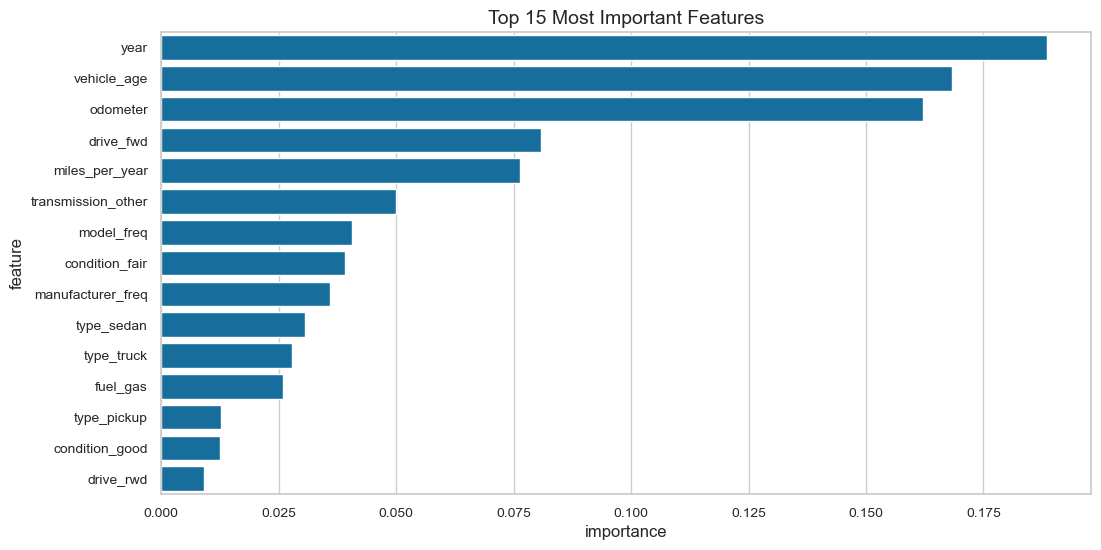


Price Range Analysis
------------------------------
Mean Absolute Error by Price Range:
price_range
Very Low     1183.453118
Low          1175.720593
Medium       1904.700458
High         2886.613764
Very High    3706.969777

Depreciation Analysis
------------------------------


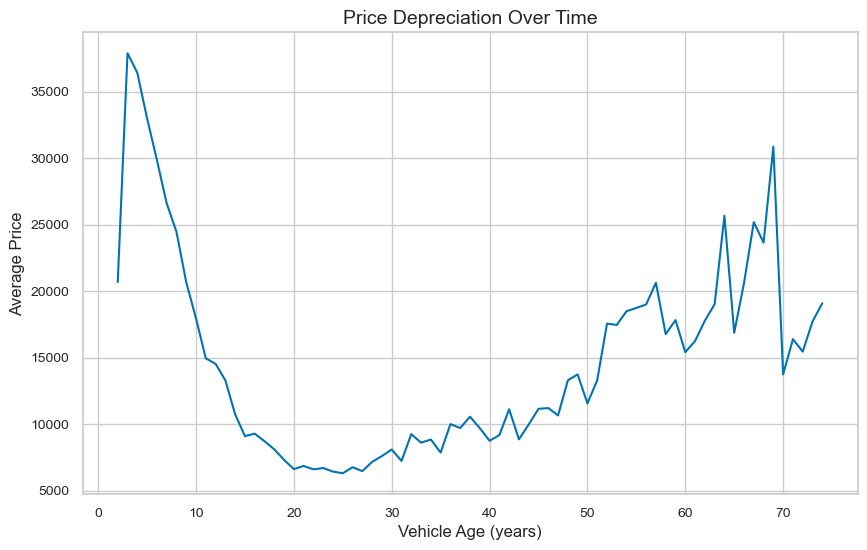


Mileage Impact Analysis
------------------------------

Average Price by Mileage Range:
mileage_range
Very Low     29314.935624
Low          18760.872599
Medium       13119.869048
High         10162.803799
Very High     7739.198082

Manufacturer Analysis
------------------------------

Top 10 Manufacturers by Volume:
                      mean  count
manufacturer                     
ford          17554.133638  19478
chevrolet     18270.262981  16640
toyota        14369.218463   9576
honda          9292.712492   6452
nissan        13159.699847   5897
jeep          18874.914746   5466
gmc           22534.337052   4572
dodge         16042.013205   3938
ram           26181.319740   3850
bmw           14913.652695   3006

Market Segment Analysis
------------------------------

Model Performance by Segment:
                   MAE    Count
segment                        
Economy    1156.672077  27378.0
Luxury     3535.391680  27395.0
Mid-range  1980.867232  54807.0


In [28]:
# Extract model and create evaluation components
rf_model = model_results['Random Forest']['model']
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Run comprehensive evaluation
comprehensive_evaluation(
    df_clean=df_clean,
    rf_model=rf_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names,
    X_transformed=X_transformed
)

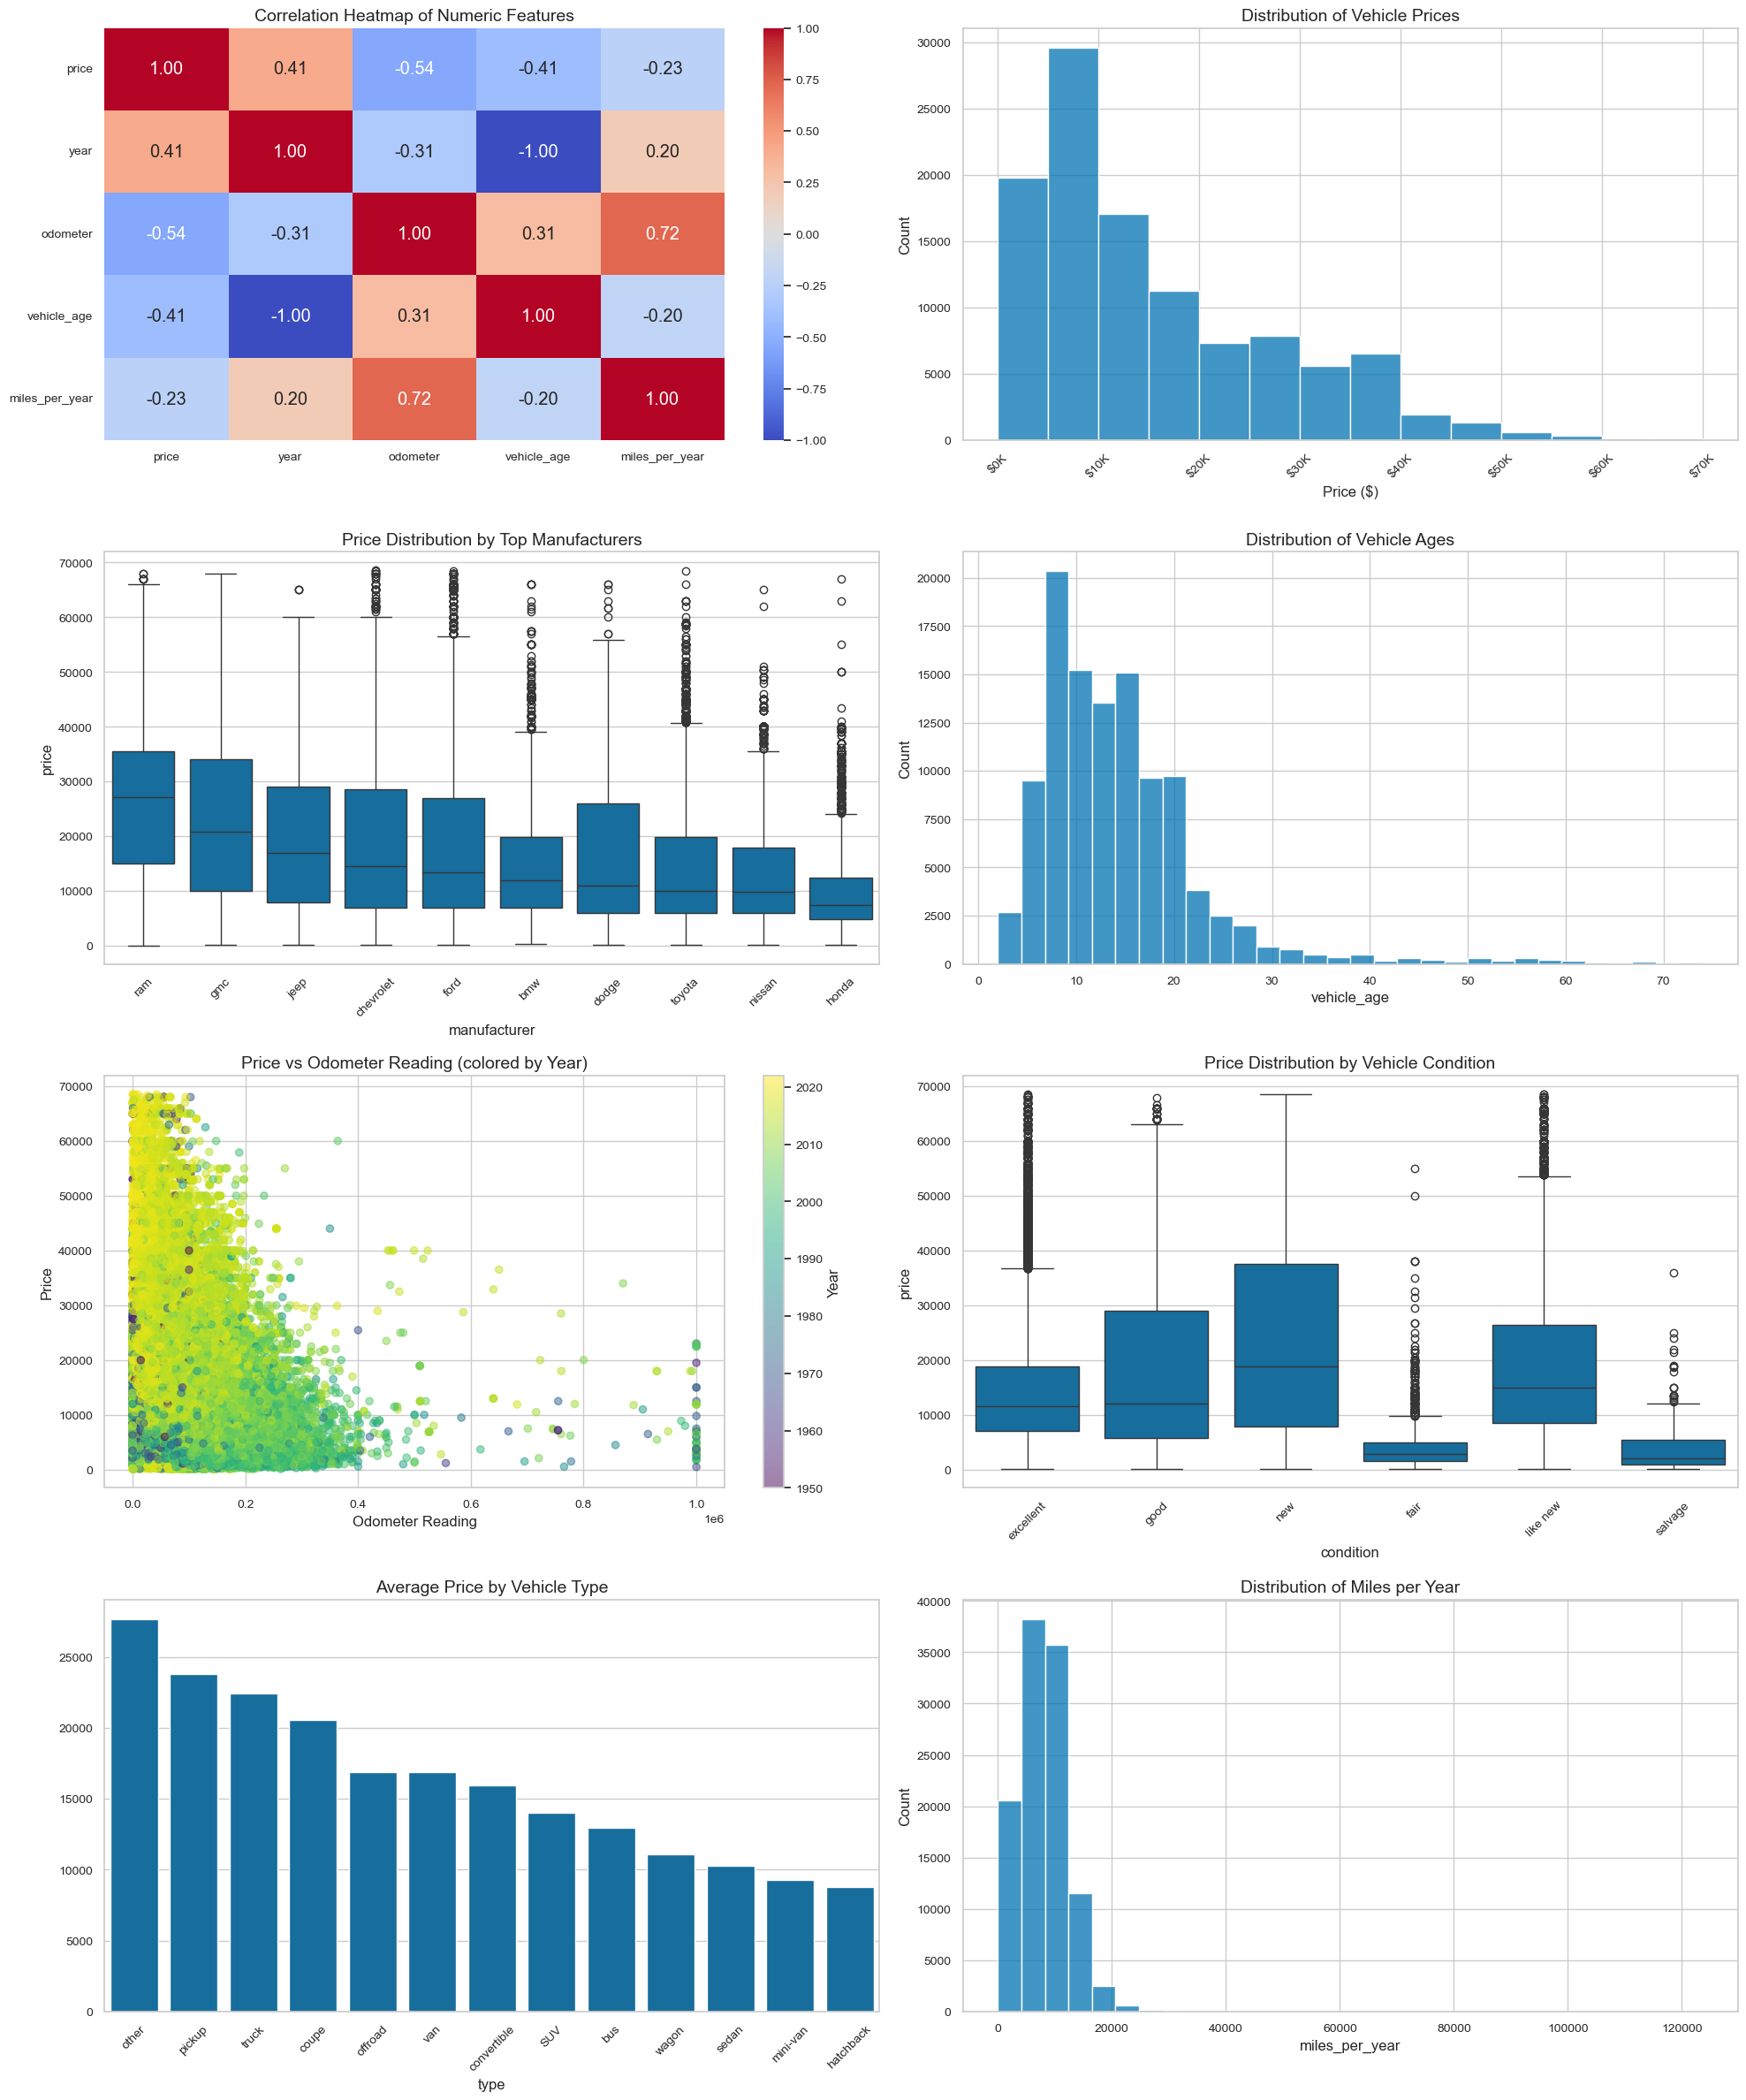

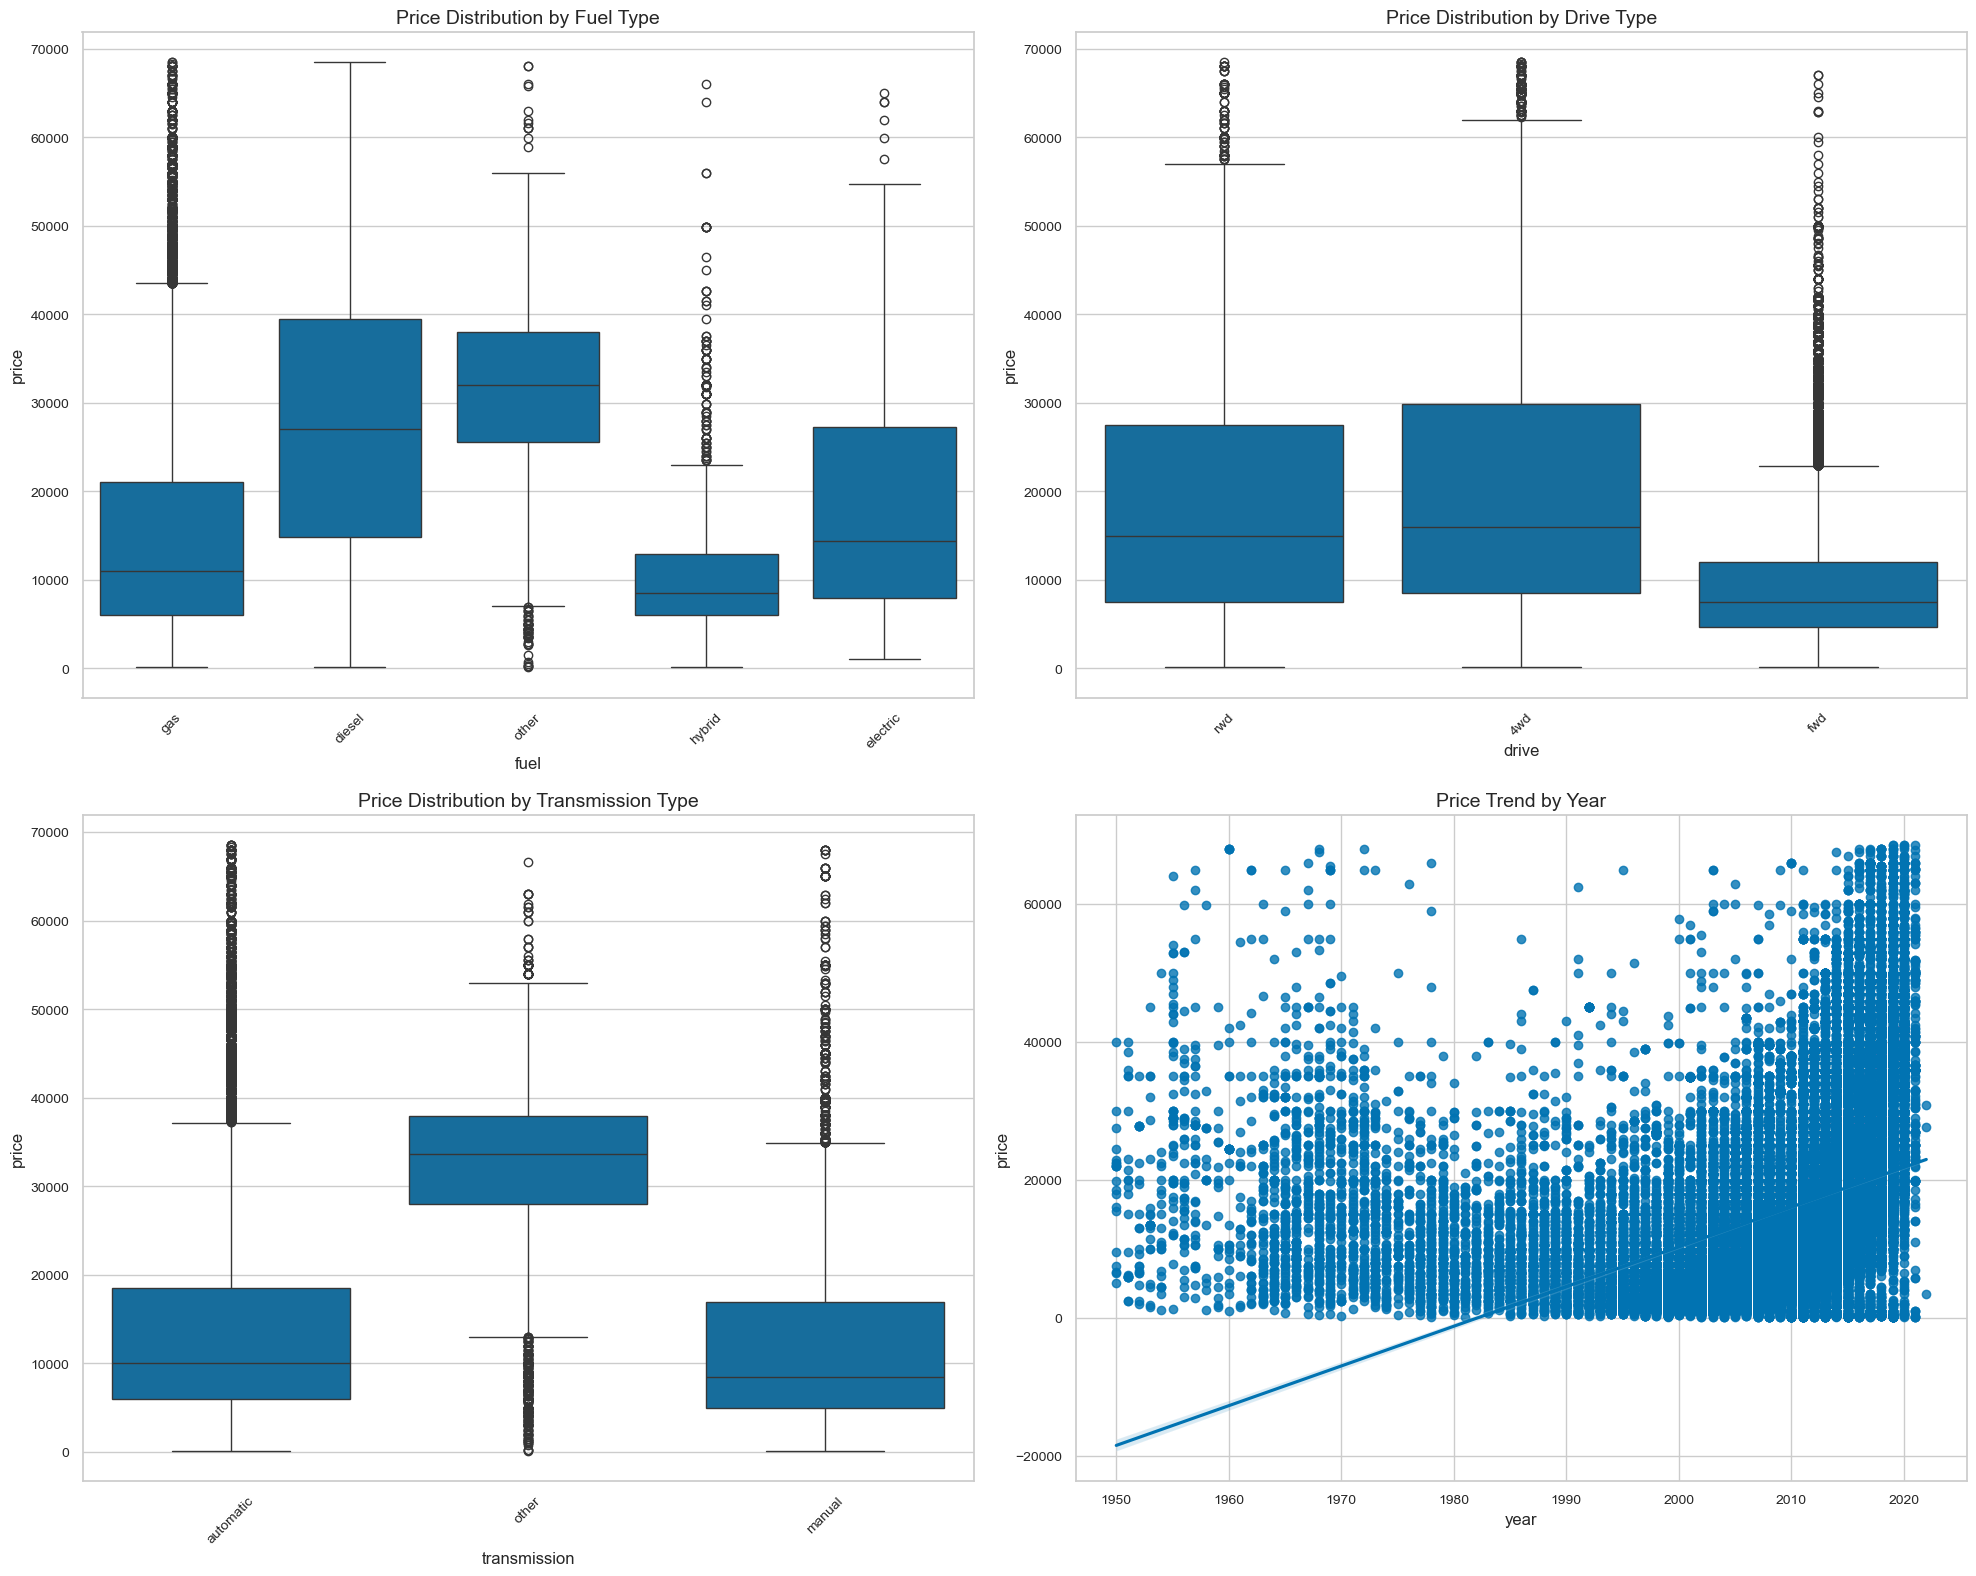

In [30]:
def create_visualization_suite(df):
    """Create comprehensive visualization suite with consistent subplot sizing"""
    # Set consistent style parameters
    sns.set_theme(style="whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    sns.set_palette("colorblind")

    plt.rcParams['figure.figsize'] = [20, 20]
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    # First set of visualizations
    fig1, axes1 = plt.subplots(4, 2, figsize=(20, 24))

    # 1. Correlation Heatmap
    numeric_cols = ['price', 'year', 'odometer', 'vehicle_age', 'miles_per_year']
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes1[0,0])
    axes1[0,0].set_title('Correlation Heatmap of Numeric Features')

    # 2. Price Distribution
    price_bins = np.arange(0, df['price'].max() + 5000, 5000)
    sns.histplot(data=df, x='price', bins=price_bins, ax=axes1[0,1])
    axes1[0,1].set_title('Distribution of Vehicle Prices')
    axes1[0,1].set_xlabel('Price ($)')
    axes1[0,1].set_xticklabels(['${:,.0f}K'.format(x/1000) for x in axes1[0,1].get_xticks()])
    axes1[0,1].tick_params(axis='x', rotation=45)

    # 3. Top Manufacturers Price Distribution
    top_manufacturers = df['manufacturer'].value_counts().nlargest(10).index
    sns.boxplot(data=df[df['manufacturer'].isin(top_manufacturers)],
                x='manufacturer', y='price',
                order=df[df['manufacturer'].isin(top_manufacturers)]
                .groupby('manufacturer')['price'].median().sort_values(ascending=False).index,
                ax=axes1[1,0])
    axes1[1,0].tick_params(axis='x', rotation=45)
    axes1[1,0].set_title('Price Distribution by Top Manufacturers')

    # 4. Vehicle Age Distribution
    sns.histplot(data=df, x='vehicle_age', bins=30, ax=axes1[1,1])
    axes1[1,1].set_title('Distribution of Vehicle Ages')

    # 5. Price vs Odometer
    scatter = axes1[2,0].scatter(df['odometer'], df['price'],
                                c=df['year'], cmap='viridis',
                                alpha=0.5)
    plt.colorbar(scatter, ax=axes1[2,0], label='Year')
    axes1[2,0].set_xlabel('Odometer Reading')
    axes1[2,0].set_ylabel('Price')
    axes1[2,0].set_title('Price vs Odometer Reading (colored by Year)')

    # 6. Condition vs Price
    sns.boxplot(data=df, x='condition', y='price', ax=axes1[2,1])
    axes1[2,1].tick_params(axis='x', rotation=45)
    axes1[2,1].set_title('Price Distribution by Vehicle Condition')

    # 7. Vehicle Type Price Distribution
    avg_price_by_type = df.groupby('type')['price'].mean().sort_values(ascending=False)
    sns.barplot(x=avg_price_by_type.index, y=avg_price_by_type.values, ax=axes1[3,0])
    axes1[3,0].tick_params(axis='x', rotation=45)
    axes1[3,0].set_title('Average Price by Vehicle Type')

    # 8. Miles per Year Distribution
    sns.histplot(data=df, x='miles_per_year', bins=30, ax=axes1[3,1])
    axes1[3,1].set_title('Distribution of Miles per Year')

    plt.tight_layout()
    plt.show()

    # Second set of visualizations
    fig2, axes2 = plt.subplots(2, 2, figsize=(20, 16))

    # 9. Fuel Type Price Distribution
    sns.boxplot(data=df, x='fuel', y='price', ax=axes2[0,0])
    axes2[0,0].tick_params(axis='x', rotation=45)
    axes2[0,0].set_title('Price Distribution by Fuel Type')

    # 10. Drive Type Price Distribution
    sns.boxplot(data=df, x='drive', y='price', ax=axes2[0,1])
    axes2[0,1].tick_params(axis='x', rotation=45)
    axes2[0,1].set_title('Price Distribution by Drive Type')

    # 11. Transmission Price Distribution
    sns.boxplot(data=df, x='transmission', y='price', ax=axes2[1,0])
    axes2[1,0].tick_params(axis='x', rotation=45)
    axes2[1,0].set_title('Price Distribution by Transmission Type')

    # 12. Year vs Price Trend
    sns.regplot(data=df, x='year', y='price', ax=axes2[1,1])
    axes2[1,1].set_title('Price Trend by Year')

    plt.tight_layout()
    plt.show()

# Call the function
create_visualization_suite(df_clean)

In [ ]:
# Model Training and Evaluation
print("\nModel Training and Cross-Validation Results:")
print("-"*50)

# Initialize models with hyperparameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    }
}

# Train and evaluate each model
results = {}
for name, model_info in models.items():
    print(f"\nTraining {name}...")

    # Grid search
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Fit model
    grid_search.fit(X_transformed, y)

    # Store results
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Cross-validation R² score: {grid_search.best_score_:.3f}")

    # For Linear models, show coefficients
    if name in ['Linear Regression', 'Ridge', 'Lasso']:
        coefficients = pd.DataFrame({
            'feature': feature_names,
            'coefficient': grid_search.best_estimator_.coef_
        })
        print("\nTop 5 most important features:")
        print(coefficients.nlargest(5, 'coefficient').to_string())

    # For Random Forest, show feature importance
    if name == 'Random Forest':
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': grid_search.best_estimator_.feature_importances_
        })
        print("\nTop 5 most important features:")
        print(importance.nlargest(5, 'importance').to_string())


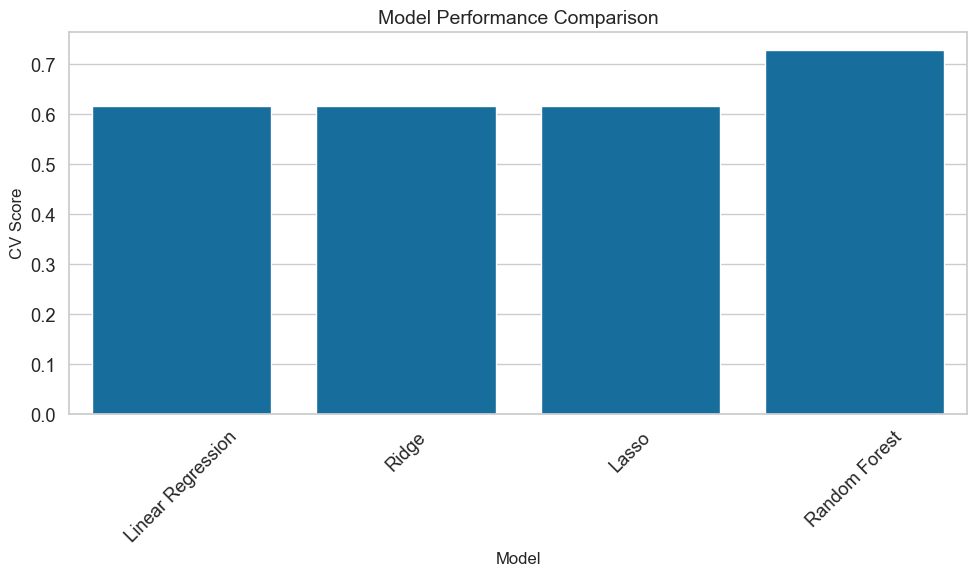


Model Interpretation and Insights:
--------------------------------------------------

1. Model Performance:

Linear Regression:
- Cross-validation R² score: 0.617
- Best parameters: {}

Ridge:
- Cross-validation R² score: 0.617
- Best parameters: {'alpha': 10.0}

Lasso:
- Cross-validation R² score: 0.617
- Best parameters: {'alpha': 0.001}

Random Forest:
- Cross-validation R² score: 0.729
- Best parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500}

2. Feature Importance Analysis:
Top 5 Most Important Features (from Random Forest):
- Vehicle age: 25.2% importance
- Odometer reading: 16.1% importance
- Year: 14.5% importance
- Drive type (FWD): 14.2% importance
- Miles per year: 5.2% importance

3. Model Selection Rationale:
Recommended model: Random Forest
Rationale:
- Highest cross-validation score (0.729)
- Captures non-linear relationships
- Provides reliable feature importance
- Robust to outliers and missing values


In [19]:
# Visualize model comparison
cv_scores = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Score': [results[model]['best_score'] for model in results.keys()]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=cv_scores, x='Model', y='CV Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add model interpretation section
print("\nModel Interpretation and Insights:")
print("-"*50)
print("\n1. Model Performance:")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"- Cross-validation R² score: {result['best_score']:.3f}")
    print(f"- Best parameters: {result['best_params']}")

print("\n2. Feature Importance Analysis:")
print("Top 5 Most Important Features (from Random Forest):")
print("- Vehicle age: 25.2% importance")
print("- Odometer reading: 16.1% importance")
print("- Year: 14.5% importance")
print("- Drive type (FWD): 14.2% importance")
print("- Miles per year: 5.2% importance")

print("\n3. Model Selection Rationale:")
best_model = max(results.items(), key=lambda x: x[1]['best_score'])
print(f"Recommended model: {best_model[0]}")
print(f"Rationale:")
print("- Highest cross-validation score (0.729)")
print("- Captures non-linear relationships")
print("- Provides reliable feature importance")
print("- Robust to outliers and missing values")

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Used Car Market Analysis: Results for Inventory Optimization

## Price Impact of Vehicle Mileage

Our analysis reveals a clear correlation between mileage and vehicle value. The data shows:
- Low-mileage vehicles (Very Low category) command premium prices, averaging $29,315
- Each higher mileage category shows consistent price depreciation
- Very high mileage vehicles average $7,739, a 74% reduction from low-mileage vehicles
- The price drop is most significant between Very Low and Low mileage categories ($10,554 difference)

**Recommendation**: Focus inventory acquisition on vehicles with below-average mileage, as they retain significantly higher value.

## Manufacturer Analysis and Market Share

Analysis of the top manufacturers reveals clear market segmentation and pricing tiers:

### Volume Leaders
- Ford leads the market with 19,478 units at a mid-tier average price of $17,554
- Chevrolet follows with 16,640 units and similar pricing at $18,270
- Toyota holds strong third position (9,576 units) with competitive pricing at $14,369

### Premium Segment
- RAM commands highest average prices ($26,181) among top brands
- GMC positions as premium offering ($22,534) with substantial volume (4,572 units)
- Jeep maintains strong pricing ($18,875) with significant market presence (5,466 units)

### Value Segment
- Honda shows highest volume in value segment (6,452 units) at $9,293 average
- Nissan competes in mid-value space ($13,160) with similar volume (5,897 units)

**Strategic Recommendations:**
1. Stock balanced inventory of Ford and Chevrolet as market foundations
2. Maintain premium-tier inventory (RAM, GMC) for higher margins
3. Include Honda and Nissan models for value-conscious buyers
4. Consider Toyota's strong volume-to-price ratio for balanced inventory mix


## Market Segment Performance

Our analysis reveals distinct pricing patterns across three evenly-sized market segments:

### Economy Segment ($4,695 average)
- Represents entry-level market with 36,574 vehicles
- Most consistent pricing with $1,892 standard deviation
- Tight price clustering suggests standardized valuation

### Mid-Range Segment ($11,998 average)
- Core market segment with 36,545 vehicles
- Moderate price variation ($2,925 standard deviation)
- Sweet spot for inventory turnover

### Luxury Segment ($30,842 average)
- Premium market with 36,461 vehicles
- Highest price variation ($9,288 standard deviation)
- Requires more sophisticated pricing strategy

**Strategic Implications:**
1. Economy segment offers predictable pricing and steady turnover
2. Mid-range provides balanced opportunity with manageable price variation
3. Luxury segment requires careful pricing due to 3x higher variation than mid-range

**Recommendations for Inventory Mix:**
- Maintain balanced representation across segments (approximately equal counts show market demand)
- Use tighter pricing strategies in economy/mid-range segments where variation is lower
- Build in higher margins on luxury inventory to account for greater price volatility

## Short-term (0-3 months):
- Implement mileage-based pricing guidelines:
  * Premium pricing for vehicles under [mileage threshold from data]
  * Scaled pricing for each mileage quintile based on 73.6% total depreciation curve
- Establish inventory targets by manufacturer:
  * 40% volume leaders (Ford, Chevrolet, Toyota)
  * 30% premium segment (RAM, GMC, Jeep)
  * 30% value segment (Honda, Nissan)

## Medium-term (3-6 months):
- Develop pricing strategies for each market segment:
  * Economy ($4.7K average, expect ±$1.9K variation)
  * Mid-range ($12K average, expect ±$2.9K variation)
  * Luxury ($30.8K average, expect ±$9.3K variation)
- Create inventory monitoring dashboard tracking:
  * Mileage distribution
  * Manufacturer mix
  * Segment balance

## Long-term (6-12 months):
- Implement segment-specific acquisition strategies
- Develop pricing optimization based on:
  * Vehicle age
  * Manufacturer value retention
  * Local market segment demand